# Medical Deep Learning
## Exercise 5: Model Distillation & Ternary Nets

The goal of this exercise is to implement methods that allow to compress deep learning models via model distillation and ternary weights. This enables the use of deep learning in medicine due to its real-time ability and implementation on weaker mobile devices.

In [ ]:
#run pip install for pytorch flop counter before first use
!pip install onnx wget
!pip install --upgrade git+https://github.com/Lyken17/pytorch-OpCounter.git

import sys

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import shutil,gzip
from IPython.utils import io

from thop import profile
import wget

#some functions to count unique parameters and sparsity are provided
def countParameters(net):
    model_parameters = filter(lambda p: p.requires_grad, net.parameters())
    params = sum([p.numel() for p in model_parameters])
    return params

def countUnique(net):
    unique = 0
    for m in net.modules():
        if(isinstance(m,nn.Conv2d)):
            unique += len(np.unique(m.weight.data.cpu().flatten().numpy()))
    return unique
    #print('#unique',unique)

def countSparsity(net):
    count_nonzero = 0; count_zero = 0
    for m in net.modules():
        if(isinstance(m, nn.Conv2d)):
            count_nonzero += torch.sum((m.weight.data!=0).float())
            count_zero += torch.sum((m.weight.data==0).float())
    return count_zero/(count_zero+count_nonzero)
            

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 12.8 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=18a7eda004959546d5f7de0ee9d9d0de853bb9f1b63132632ff8970c2c1766e9
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Lyken17/pytorch-OpCounter.git to /tmp/pip-req-build-1p_dib8l
  Running command git clone -q https://github.com/Lyken17/pytorch-OpCounter.git /tmp/pip-req-build-1p_dib8l
  Created wheel for thop: filename=thop-0.1.0.post2206151211-py3-none-any.whl size=15222 sha256=467304897236ff553e7b100e450c321a7378eebaacd559cf80ceb2fadeb6ecf8
  Stored in directory: /tmp/pip-ephem-wheel-cache-bseizdl0/wheels/aa/e7/25/c280567dc2e6a1f3aadf802f16129960793

## Dataset
We will use the data of the Patch Camelyon (tupac16) Challenge. It consists of $327\,680$ color images extracted from histopathologic scans of lymph node sections. The task is to classify the presence of metastatic tissue (global binary labels are given). The images were preprocessed to a spatial dimension of $48\times48$ and split to 65k for training and 16k for testing images. See [here](https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview) for further details.

In [ ]:
#loading the patch-based wholeslide histopathology data (uint8) and converting it to torch tensors
import os

dataset_url = 'https://cloud.imi.uni-luebeck.de/s/sjjiReHqSnokJ2n/download'

def get_data(data_url):
    filename = './patchCamelyon8c.mat'
    if not os.path.exists(filename):
        filename = wget.download(data_url)
    
get_data(dataset_url)


data = scipy.io.loadmat('patchCamelyon8c.mat')

img_train = torch.from_numpy(data['img_train'].astype('float32')/255)
img_test = torch.from_numpy(data['img_test'].astype('float32')/255)

label_train = torch.from_numpy(data['label_train']).long()
label_test = torch.from_numpy(data['label_test']).long()

Let's visualize an example for the two classes. You can run the cell multiple times, getting each time new random examples.

index for no metastatic tissue: 45453
index for metastatic tissue: 55377


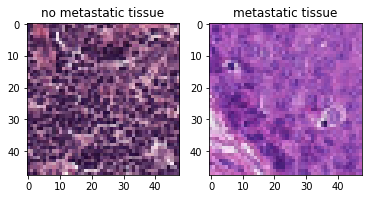

In [ ]:
fig, [ax1, ax2] = plt.subplots(1, 2)
idx_negative = torch.where(label_train.squeeze() == 0)[0]
idx_negative = idx_negative[torch.randperm(len(idx_negative))[0]]

idx_positive = torch.where(label_train.squeeze() == 1)[0]
idx_positive = idx_positive[torch.randperm(len(idx_positive))[0]]

print('index for no metastatic tissue:', idx_negative.item())
print('index for metastatic tissue:', idx_positive.item())

ax1.imshow(img_train[idx_negative].permute(1, 2, 0))
ax1.set_title('no metastatic tissue')
ax2.imshow(img_train[idx_positive].permute(1, 2, 0))
ax2.set_title('metastatic tissue')
plt.show()

In [ ]:
# install torchinfo library
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We load a pretrained `VGG11`, inspect its architecture and gather some computational information.

In [ ]:
from torchinfo import summary
net = torchvision.models.vgg11_bn(pretrained='True')

summary(net, (128, 3, 48, 48))

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [128, 1000]               --
├─Sequential: 1-1                        [128, 512, 1, 1]          --
│    └─Conv2d: 2-1                       [128, 64, 48, 48]         1,792
│    └─BatchNorm2d: 2-2                  [128, 64, 48, 48]         128
│    └─ReLU: 2-3                         [128, 64, 48, 48]         --
│    └─MaxPool2d: 2-4                    [128, 64, 24, 24]         --
│    └─Conv2d: 2-5                       [128, 128, 24, 24]        73,856
│    └─BatchNorm2d: 2-6                  [128, 128, 24, 24]        256
│    └─ReLU: 2-7                         [128, 128, 24, 24]        --
│    └─MaxPool2d: 2-8                    [128, 128, 12, 12]        --
│    └─Conv2d: 2-9                       [128, 256, 12, 12]        295,168
│    └─BatchNorm2d: 2-10                 [128, 256, 12, 12]        512
│    └─ReLU: 2-11                        [128, 256, 12, 12]        --


## Task 0: Modify a pretrained VGG11_BN network for the given training data
Complete the function below, which returns a VGG11-Net with its architecture modified accordingly to match the tupac16 dataset.
+ Replace the layer `net.avgpool` with an adaptive average pool of output size $1\times1$
+ Create a new classifier as `nn.Sequential` with two linear layers ($512\times256$ and $256\times2$) including one ReLU and no batch-norm.

In [ ]:
def tupac16_vgg11():
    net = torchvision.models.vgg11_bn(pretrained='True')
    net.avgpool = nn.AdaptiveAvgPool2d((1,1)) # todo
    net.classifier = nn.Sequential(
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 2)
    ) # todo
    
    return net

Check the reduced parameter count using `summary` from `torchinfo`. Your should obtain about $9\,357\,826$ parameters.

In [ ]:
# todo
net = tupac16_vgg11()

#summary(net, (128, 3, 48, 48))
summary(net)

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─BatchNorm2d: 2-2                  128
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
│    └─Conv2d: 2-5                       73,856
│    └─BatchNorm2d: 2-6                  256
│    └─ReLU: 2-7                         --
│    └─MaxPool2d: 2-8                    --
│    └─Conv2d: 2-9                       295,168
│    └─BatchNorm2d: 2-10                 512
│    └─ReLU: 2-11                        --
│    └─Conv2d: 2-12                      590,080
│    └─BatchNorm2d: 2-13                 512
│    └─ReLU: 2-14                        --
│    └─MaxPool2d: 2-15                   --
│    └─Conv2d: 2-16                      1,180,160
│    └─BatchNorm2d: 2-17                 1,024
│    └─ReLU: 2-18                        --
│    └─Conv2d: 2-19                     

In [ ]:
summary(net, (128, 3, 48, 48))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [128, 2]                  --
├─Sequential: 1-1                        [128, 512, 1, 1]          --
│    └─Conv2d: 2-1                       [128, 64, 48, 48]         1,792
│    └─BatchNorm2d: 2-2                  [128, 64, 48, 48]         128
│    └─ReLU: 2-3                         [128, 64, 48, 48]         --
│    └─MaxPool2d: 2-4                    [128, 64, 24, 24]         --
│    └─Conv2d: 2-5                       [128, 128, 24, 24]        73,856
│    └─BatchNorm2d: 2-6                  [128, 128, 24, 24]        256
│    └─ReLU: 2-7                         [128, 128, 24, 24]        --
│    └─MaxPool2d: 2-8                    [128, 128, 12, 12]        --
│    └─Conv2d: 2-9                       [128, 256, 12, 12]        295,168
│    └─BatchNorm2d: 2-10                 [128, 256, 12, 12]        512
│    └─ReLU: 2-11                        [128, 256, 12, 12]        --


In [ ]:
# count parameters of the network
countParameters(net)

9357826

## Task1: Fine tuning
Fine-tune this network for 16 sub-epochs on the tupac16 dataset. One sub-epoch is defined as a random quarter of the training pathes. Use `torch.randperm` to generate the needed indices for every epoch. The batch size should be 128. Choose Adam as an optimizer with an initial learning rate of 0.0005 and an exponential learning rate scheduler with `gamma=0.9`. After training, evaluate the model on the test data. It should yield an accuracy about $94\%$.

**Note:** Task 2 and 3 can be performed independently, but you should store each trained network under a new filename (for comparisons). In the following all techniques should only be applied to the feature-part of the network (and not the classifier layers).

**Hint**: If you struggle with implementing of the training routine, have a look at the previous exercises.

In [ ]:
from tqdm.autonotebook import tqdm
from tqdm import trange
sub_epochs = 16
batch_size = 128
initial_learning_rate = 0.0005
gamma = 0.9

In [ ]:
# Task1 - Training loop

# todo
from tqdm.autonotebook import tqdm
from tqdm import trange
sub_epochs = 16
batch_size = 128
initial_learning_rate = 0.0005
gamma = 0.9

# optimizer
optimizer = optim.Adam(net.parameters(), lr=initial_learning_rate)
# learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=gamma)
# criterion
criterion = nn.CrossEntropyLoss().cuda()
# for reproducibility
torch.manual_seed(0)

# statistics
train_loss = torch.zeros(sub_epochs).cuda()
train_acc = torch.zeros_like(train_loss).cuda()

for epoch in tqdm(range(sub_epochs)):
  # generate indices for every epoch
  perm = torch.randperm(img_train.shape[0]) # 65536

  for batch_idx in range(0, perm.shape[0]//4, batch_size):
    
    # zero the parameter gradients
    optimizer.zero_grad()

    # get the batch
    batch_image = img_train[perm[batch_idx:batch_idx+batch_size]]
    batch_target = label_train[0,perm[batch_idx:batch_idx+batch_size]]

    # forward + backward + optimize
    output = net(batch_image.cuda()).cuda()
    loss = criterion(output.cuda(), batch_target.cuda())
    loss.backward()
    optimizer.step()

    # statistics
    train_loss[epoch] += loss
  #  train_acc[epoch] += torch.mean(torch.argmax(output, dim=-1) == batch_target.cuda()).float()
    train_acc[epoch] += torch.mean((torch.argmax(output, dim=-1) == batch_target.cuda()).float())
  #output.argmax(0)
  # update learning rate
  scheduler.step()
  train_loss[epoch] /= batch_size # mini-batch size - have a look at it again
  train_acc[epoch] /= batch_size 
  tqdm.write('Epoch {} (train) -- loss: {:.4f} accuracy: {:.4f}'.format(epoch, train_loss[epoch].item(), train_acc[epoch].item()))

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 0 (train) -- loss: 0.3403 accuracy: 0.8531
Epoch 1 (train) -- loss: 0.2483 accuracy: 0.8995
Epoch 2 (train) -- loss: 0.2134 accuracy: 0.9163
Epoch 3 (train) -- loss: 0.1826 accuracy: 0.9307
Epoch 4 (train) -- loss: 0.1588 accuracy: 0.9406
Epoch 5 (train) -- loss: 0.1360 accuracy: 0.9490
Epoch 6 (train) -- loss: 0.1163 accuracy: 0.9578
Epoch 7 (train) -- loss: 0.1018 accuracy: 0.9633
Epoch 8 (train) -- loss: 0.0837 accuracy: 0.9701
Epoch 9 (train) -- loss: 0.0764 accuracy: 0.9730
Epoch 10 (train) -- loss: 0.0622 accuracy: 0.9799
Epoch 11 (train) -- loss: 0.0497 accuracy: 0.9827
Epoch 12 (train) -- loss: 0.0410 accuracy: 0.9872
Epoch 13 (train) -- loss: 0.0341 accuracy: 0.9891
Epoch 14 (train) -- loss: 0.0310 accuracy: 0.9895
Epoch 15 (train) -- loss: 0.0233 accuracy: 0.9930


In [ ]:
torch.save(net, "task1.pth")

In [ ]:
img_test.shape

torch.Size([16384, 3, 48, 48])

In [ ]:
# Test loop, evaluate the model on the test data

# load the model
net = torch.load("task1.pth").cuda()
net.eval()
test_loss = 0
test_accuracy = 0

#test_loss = torch.zeros_like(train_loss).cuda()
#test_acc = torch.zeros_like(train_loss).cuda()

for batch_idx in range(0, img_test.shape[0], batch_size):
  with torch.no_grad():
    # get the batch
    batch_image = img_test[batch_idx:batch_idx+batch_size].cuda()
    batch_target = label_test[0, batch_idx:batch_idx+batch_size].cuda()
    # prediction
    output = net(batch_image)
    # metrics
    loss = criterion(output.cuda(), batch_target.cuda())
    # statistics
    test_loss += loss.cuda()
    test_accuracy += torch.mean((torch.argmax(output, dim=-1) == batch_target.cuda()).float()).cuda() 

print("Accuracy: ", test_accuracy/((img_test.shape[0])/batch_size), "Loss: ", test_loss/((img_test.shape[0])/batch_size))


Accuracy:  tensor(0.9327, device='cuda:0') Loss:  tensor(0.2603, device='cuda:0')


## Task 2: Network Pruning through increased Sparsity
+ Start with the same modified, pre-trained (not fine-tuned) vgg11_bn as before by calling your `tupac16_vgg11` method. 
+ Reuse the training routine from above.
+ Add a sparsity promoting L1-loss (sum of absolute values) with a weight factor of 0.04 to the classification loss on the weights and bias of each BatchNorm2d.
    + Therefor iterate over all modules of the net using `modules()` and determine the layer type using `isinstance()`
+ Retrain the network.
+ Evaluate its test accuracy (will drop slightly to ~89%).

In [ ]:
# Task 2
# call the network
net = tupac16_vgg11()
net.cuda()

sub_epochs = 16
batch_size = 128
initial_learning_rate = 0.0005
gamma = 0.9
sparsity_weight_factor = 0.04

# optimizer
optimizer = optim.Adam(net.parameters(), lr=initial_learning_rate)
# learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=gamma)
# criterion
criterion = nn.CrossEntropyLoss().cuda()
# for reproducibility
torch.manual_seed(0)

# statistics
train_loss = torch.zeros(sub_epochs).cuda()
train_acc = torch.zeros_like(train_loss).cuda()

for epoch in tqdm(range(sub_epochs)):
  # generate indices for every epoch
  perm = torch.randperm(img_train.shape[0]) # 65536

  for batch_idx in range(0, perm.shape[0]//4, batch_size):
    
    # zero the parameter gradients
    optimizer.zero_grad()

    # get the batch
    batch_image = img_train[perm[batch_idx:batch_idx+batch_size]]
    batch_target = label_train[0,perm[batch_idx:batch_idx+batch_size]]

    # forward
    output = net(batch_image.cuda())
    loss = criterion(output.cuda(), batch_target.cuda())

    # sparsity promoting L1-loss
    loss_sparsity = 0
    for module in net.modules():
      if isinstance(module, nn.BatchNorm2d):
        loss_sparsity += sparsity_weight_factor*module.weight.abs().sum()
        loss_sparsity += sparsity_weight_factor*module.bias.abs().sum()

    loss += loss_sparsity
    # backward + optimize
    loss.backward()
    optimizer.step()

    # statistics
    train_loss[epoch] += loss
    train_acc[epoch] += torch.mean((torch.argmax(output, dim=-1) == batch_target.cuda()).float())

  # update learning rate
  scheduler.step()
  train_loss[epoch] /= batch_size # mini-batch size - have a look at it again
  train_acc[epoch] /= batch_size 
  tqdm.write('Epoch {} (train) -- loss: {:.4f} accuracy: {:.4f}'.format(epoch, train_loss[epoch].item(), train_acc[epoch].item()))

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 0 (train) -- loss: 74.5082 accuracy: 0.8521
Epoch 1 (train) -- loss: 61.6918 accuracy: 0.8962
Epoch 2 (train) -- loss: 50.7413 accuracy: 0.9091
Epoch 3 (train) -- loss: 41.5764 accuracy: 0.9155
Epoch 4 (train) -- loss: 34.1898 accuracy: 0.9174
Epoch 5 (train) -- loss: 28.6649 accuracy: 0.9140
Epoch 6 (train) -- loss: 24.7824 accuracy: 0.9110
Epoch 7 (train) -- loss: 22.0436 accuracy: 0.9124
Epoch 8 (train) -- loss: 19.9952 accuracy: 0.9160
Epoch 9 (train) -- loss: 18.3900 accuracy: 0.9174
Epoch 10 (train) -- loss: 17.0657 accuracy: 0.9163
Epoch 11 (train) -- loss: 15.9403 accuracy: 0.9219
Epoch 12 (train) -- loss: 14.9715 accuracy: 0.9251
Epoch 13 (train) -- loss: 14.1379 accuracy: 0.9286
Epoch 14 (train) -- loss: 13.4180 accuracy: 0.9257
Epoch 15 (train) -- loss: 12.7852 accuracy: 0.9269


In [ ]:
torch.save(net, "tupac_sparse_net.pth")

In [ ]:
# Test loop, evaluate the model on the test data

# load the model
net = torch.load("tupac_sparse_net.pth").cuda()
net.eval()
test_loss = 0
test_accuracy = 0


for batch_idx in range(0, img_test.shape[0], batch_size):
  with torch.no_grad():
    # get the batch
    batch_image = img_test[batch_idx:batch_idx+batch_size].cuda()
    batch_target = label_test[0, batch_idx:batch_idx+batch_size].cuda()
    # prediction
    output = net(batch_image)
    # metrics
    loss = criterion(output.cuda(), batch_target.cuda())
    # statistics
    test_loss += loss.cuda()
    test_accuracy += torch.mean((torch.argmax(output, dim=-1) == batch_target.cuda()).float()).cuda() 

print("Accuracy: ", test_accuracy/((img_test.shape[0])/batch_size), "Loss: ", test_loss/((img_test.shape[0])/batch_size))

Accuracy:  tensor(0.8922, device='cuda:0') Loss:  tensor(0.2718, device='cuda:0')


In [ ]:
import torch.nn.utils.prune as prune

Write a function that determines a threshold for input/output neurons to be set to zero (the ones which have been reduced in absolute value using the sparsity constraint). You can use the function `topk`, which outputs both the values and indices sorted around a chosen quantile/percentile. Here we simply use the median to set 50% of values to zero.

When applied correctly (as incoming & outgoing mask) for each Conv2d layer, it reduces the nonzero parameters by ~75% (the first incoming & last outgoing Conv2d are not masked). 
Note that BatchNorm has four tensors and two index masks have to be applied as follows:

`B = A[idx_next,:,:,:][:,idx_prev,:,:]`
 
Now you can replace all Conv2d and BatchNorm2d layers with smaller filters (and copy their weights) so that we have the following sequence of channels: 3, 32, 64, (2x)128, (3x)256, 512.
Evaluate the slimmed network (you could observe a slight improvement to ~92%) and confirm that the required computations are reduced to 12 GFlops.

In [ ]:
# task 2 Network slimming (construct lean filters)

sparsity_s = 0.04
ternary = False

model_name = 'tupac_sparse'

net = torch.load(model_name+'_net.pth')

net.eval()
net.cuda()

mask = torch.ones(3).cuda()
idx_prev = torch.arange(3).long().cuda()
q75 = 0.5 
print('#params before',countParameters(net.features))
print('#features sparsity',countSparsity(net.features))


for c in range(len(net.features)-2):
    if isinstance(net.features[c], nn.Conv2d):
        print(net.features[c].weight.shape, c)
        if(c==25):
            q75=1
        else:
            q75=0.5
        
        net_weight = net.features[c].weight.data.clone().detach()
        net_bias = net.features[c].bias.data.clone().detach()

        w_values, w_indices = torch.topk(net_weight, int(q75*int(net.features[c].weight.shape[0])), largest=True, dim=0)
        b_values, b_indices = torch.topk(net_bias, int(q75*int(net.features[c].bias.shape[0])), largest=True, dim=0)

        print("w values: ", w_values.shape)
        print("network shape: ", net.features[c].weight.data.shape)
        
        
        
        #prune.l1_unstructured(net.features[c], name='weight', amount = q75)
        #prune.l1_unstructured(net.features[c], name='bias', amount = q75)
        
        #print("bias shape: ", b_values.shape)
        #net.features[c].weight.data = torch.reshape(net.features[c].weight.data, w_values.shape)
        #net.features[c].weight.data.resize(w_values.shape)
        #net.features[c].weight.data = w_values
        
        print(net.features[c])
        print("\n")

# evaluation for task 2
        
print('#params after',countParameters(net.features))
print('#features sparsity',countSparsity(net.features))    

idx_epoch = torch.arange(16384).view(128,-1)
val_acc = 0

for iter in range(idx_epoch.size(1)):
    idx_iter = idx_epoch[:,iter]

    with torch.no_grad():
        #forward path and loss
        outputs = net(img_test[idx_iter,:,:,:].cuda())
    val_acc += torch.sum((outputs.argmax(1).cpu()==label_test[0,idx_iter]).float())/16384.0

print(val_acc)

#params before 9225984
#features sparsity tensor(0., device='cuda:0')
torch.Size([64, 3, 3, 3]) 0
w values:  torch.Size([32, 3, 3, 3])
network shape:  torch.Size([64, 3, 3, 3])
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


torch.Size([128, 64, 3, 3]) 4
w values:  torch.Size([64, 64, 3, 3])
network shape:  torch.Size([128, 64, 3, 3])
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


torch.Size([256, 128, 3, 3]) 8
w values:  torch.Size([128, 128, 3, 3])
network shape:  torch.Size([256, 128, 3, 3])
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


torch.Size([256, 256, 3, 3]) 11
w values:  torch.Size([128, 256, 3, 3])
network shape:  torch.Size([256, 256, 3, 3])
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


torch.Size([512, 256, 3, 3]) 15
w values:  torch.Size([256, 256, 3, 3])
network shape:  torch.Size([512, 256, 3, 3])
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


torch.Size([512

In [ ]:
net.features[0]

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [ ]:
net_bias.shape

torch.Size([512])

In [ ]:
indices.shape

torch.Size([32, 3, 3, 3])

In [ ]:
net_weight.shape

torch.Size([64, 3, 3, 3])

In [ ]:
int(q75*int(net.features[c].weight.shape[0]))

32

In [ ]:
q75

1

In [ ]:
net.features[c].weight[0]

tensor([[[-0.5896, -0.8308, -0.5083],
         [ 0.0500, -0.0525, -0.2003],
         [ 0.6174,  0.9220,  0.6125]],

        [[-0.8951, -1.3046, -0.8726],
         [ 0.0917,  0.0184, -0.1879],
         [ 0.9146,  1.4030,  0.9184]],

        [[-0.3621, -0.5890, -0.3220],
         [ 0.0375,  0.0480, -0.0895],
         [ 0.3749,  0.7191,  0.4137]]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [ ]:
net.features[c].weight.shape[0]

64

In [ ]:
net.features[0].bias

Parameter containing:
tensor([-1.0794e-02,  3.3751e-06,  6.4761e-03,  6.5307e-05,  6.4158e-03,
        -1.3346e-04,  2.6793e-03,  3.7739e-05,  3.5372e-03,  1.6373e-04,
        -3.3048e-03, -6.4630e-04,  6.1766e-03, -1.7028e-03,  5.0567e-03,
         2.7632e-04,  1.2097e-04,  1.8197e-03,  5.0811e-03, -1.7555e-03,
        -8.6092e-03, -4.2471e-03,  5.2624e-04,  4.3686e-04, -1.1034e-02,
        -7.1486e-04, -7.7771e-05, -7.7635e-03,  3.0506e-03,  5.5333e-06,
         8.8666e-03, -8.9833e-03, -3.9763e-05, -3.4211e-05, -3.4086e-03,
        -1.6317e-04,  8.7572e-04, -1.4484e-02, -6.9707e-03,  9.9930e-03,
        -2.5518e-05, -1.2925e-05, -6.3174e-03,  9.5794e-05, -5.0242e-03,
        -4.7996e-03,  1.3261e-03,  6.0596e-05, -1.6530e-03,  1.0533e-02,
         3.6425e-04,  6.2488e-03,  5.2746e-03, -2.4672e-03, -2.5817e-04,
        -9.6024e-03, -9.2109e-06, -6.0453e-03, -3.4167e-04,  1.4066e-03,
        -7.6708e-05,  2.2919e-04, -1.4599e-04, -5.4157e-03], device='cuda:0',
       requires_grad=Tru

In [ ]:
torch.save(net, "task2.pth")

## Task 3: 
Start with the same modified, pre-trained (not fine-tuned) vgg11_bn as before. Finally, we want to explore, how the memory storage can be reduced with little loss. Here a ternary weight approximation will be used for which we first estimate a per-channel $\Delta$ for each weight in Conv2d given the rule-of-thumb below.

$\begin{align}
    \Delta &= \frac{0.7}{n}\sum^n_{i=1}|W_i|\\
    \tilde{W}_i&=
    \begin{cases}
        +1, &\text{ if } W_i > \Delta\\
        0,  &\text{ if } |W_i| \leq \Delta\\
        -1,  &\text{ else }
    \end{cases}\\
    n_\Delta &= \sum_i|\tilde{W}_i|\\
    \alpha &= \frac{1}{n_\Delta}\sum_i|\tilde{W}_i||W_i|
\end{align}$

Tip: after calculating the absolute values the mean has to be computed over all but the 0-th dimension.
The obtained ternary weights have lost their magnitude, therefore the parameter $\alpha$ (again per-channel) is computed and multiplied with the weight tensor.

Test your function with the check implemented below. For a $128\times64\times3\times3$ kernel the number of unique entries is reduced from more than 70 thousand to just 257 ($2 \cdot 128 + 1$).

In [ ]:
# call the network
net = tupac16_vgg11()

In [ ]:
# template for function in task 3
def approx_weights(w_in,flag=True):
    if(flag):
        with torch.no_grad():
            a,b,c,d = w_in.size() # w_in shape: [256, 128, 3, 3]
            delta = 1# todo
            alpha = 1# todo
            w_out = 1# todo
    else:
        w_out = w_in
    return w_out

# check the number of unique values before/after ternary approximation 
w_in = net.features[8].weight.clone().detach() 
w_approx = approx_weights(w_in,True)
print('#unique',len(np.unique(w_in.data.cpu().flatten().numpy())))
#print('#unique',len(np.unique(w_approx.data.cpu().flatten().numpy())))

#unique 294467


In [ ]:
w_in.shape

torch.Size([256, 128, 3, 3])

In [ ]:
a, b, c, d = w_in.size()

In [ ]:
a

256

To effectively train a network with weight quantisation, it is important to only use the ternary weights during forward/backward path, but update their gradients in full precision.

Implement a loop that stores full precision weights in a list of tensors and replaces the `.data` values with their approximation just before calling the forward pass (and zero_grad).
Reassign these backup copies after `loss.backward()` and `before optimizer.step()`. Retrain your network and take care to perform the weight quantisation the same way during test evaluation. The test accuracy should be around 85-90% during the epochs.

**Tip:** you could use `.pop(0)` to (iteratively) access and remove the first object of a list.

In [ ]:
# todo

In [ ]:
#Note: you can calculate the compressed model size (37MB to 2.8MB) with the following code snippet:
print(model_name)
torch.save(net.features.cpu().state_dict(),model_name+'_feat.pth')
with open(model_name+'_feat.pth', 'rb') as f_in, gzip.open(model_name+'_feat.pth.gz', 'wb') as f_out:
   shutil.copyfileobj(f_in, f_out)
os.path.getsize(model_name+'_feat.pth.gz') / (1024**2)